# A/B Test of Globox's new 'Food and Drink' banner
### The banner highlights key products in this category and displays them at the top of the website
### The control group does not see the banner, the test group sees it as shown below
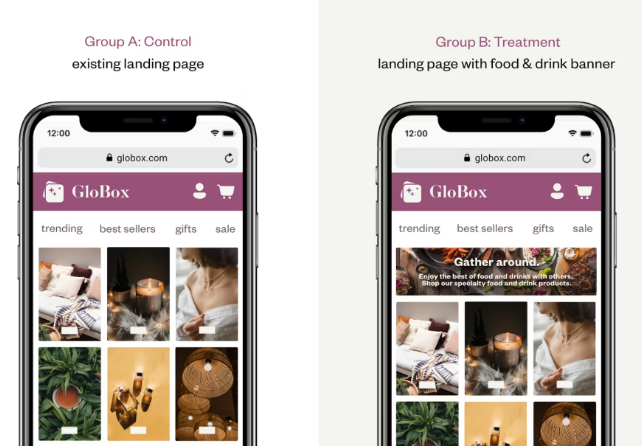
### The setup for the A/B test is as follows
1. The experiment is only being run on the mobile website.
2. A user visits the GloBox main page and is randomly assigned to either the control or test group. This is the join date for the user. The page loads the banner if the user is assigned to the test group, and does not load the banner if the user is assigned to the control group.
3. The user subsequently may or may not purchase products from the website. It could be on the same day they join the experiment, or days later. If they do make one or more purchases, this is considered a “conversion”.

### TL:DR / Summary
- There is **no statistically significant difference** between the amount spent per user in the *Control group* and *Treatment group*.
- There is **a statistically significant difference** between the conversion rates of users in each group, with the *Treatment group* having a higher average of **4.62%** compared to the *Control group's* **3.91%**.
- It is recommended to implement the *'Food and drink* banner change to Globox's mobile site.

### Method
For this test I decided to tackle to problem in Python, to do this I needed to extract all the data from the SQL tables into a .CSV file which I could then import into a pandas dataframe. 
The SQL code I used to combine the data is shown below along with inserting the .CSV into a dataframe:

SELECT id AS users_id, country, gender,  
    groups.group as cust_group, join_dt as join_date, groups.device as group_device,  
    dt as date, activity.device as activity_device, spent  
FROM users  
FULL JOIN groups ON users.id = groups.uid  
FULL JOIN activity ON users.id = activity.uid

In [63]:
import pandas as pd
from scipy.stats import t
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load the CSV file into a pandas DataFrame
file_path = r'C:\Users\kit\OneDrive\Documents\Masterschool Docs\mastery_project.csv'
raw_df = pd.read_csv(file_path)

# Replace null values with zeros
raw_df.fillna(0.0, inplace=True)
raw_df['date'].replace(0, np.nan, inplace=True)
print(raw_df.head())

   users_id country gender cust_group   join_date group_device date activity_device  spent
0   1000000     CAN      M          B  28/01/2023            I  NaN             0.0    0.0
1   1000001     BRA      M          A  27/01/2023            A  NaN             0.0    0.0
2   1000002     FRA      M          A  01/02/2023            A  NaN             0.0    0.0
3   1000003     BRA      M          B  25/01/2023            I  NaN             0.0    0.0
4   1000004     DEU      F          A  04/02/2023            A  NaN             0.0    0.0


From here, I split the dataframe in two, dependant on if the user was in group A or B

In [64]:
# Setup control and treatment variants of the dataframe
control_df = raw_df[raw_df['cust_group'] == 'A']
treatment_df = raw_df[raw_df['cust_group'] == 'B']
print(control_df.head())
print(treatment_df.head())

   users_id country gender cust_group   join_date group_device date activity_device  spent
1   1000001     BRA      M          A  27/01/2023            A  NaN             0.0    0.0
2   1000002     FRA      M          A  01/02/2023            A  NaN             0.0    0.0
4   1000004     DEU      F          A  04/02/2023            A  NaN             0.0    0.0
7   1000007     BRA      F          A  25/01/2023            A  NaN             0.0    0.0
8   1000008     BRA      F          A  05/02/2023            A  NaN             0.0    0.0
    users_id country gender cust_group   join_date group_device date activity_device  spent
0    1000000     CAN      M          B  28/01/2023            I  NaN             0.0    0.0
3    1000003     BRA      M          B  25/01/2023            I  NaN             0.0    0.0
5    1000005     GBR      F          B  26/01/2023            A  NaN             0.0    0.0
6    1000006     ESP      M          B  31/01/2023            A  NaN             0.0  

As this test depends on whether a user spent money or not, lets check that these new dataframes have formed correctly and calculate the average spent per user for the control and treatment groups. To do this I created a function which groups a dataframe by ***'users_id'***  and sums the ***'spent'*** column.

In [65]:
# Calculate the average spent by each user for both variants
def avg_spent(x1):
    total_spent = x1.groupby('users_id')['spent'].sum()         # Grouping by user allows all purchases by one user to be summed 
    average_spent = total_spent.mean()
    return average_spent

# Calculate the average spent by each user for both variants
# Control
average_spent_control = avg_spent(control_df)
print("Control Average: " + str(average_spent_control))
# Treatment
average_spent_treatment = avg_spent(treatment_df)
print("Treatment Average: " + str(average_spent_treatment) + "\n")

Control Average: 3.37451846793189
Treatment Average: 3.3908669458898792



This looks accurate as the majority of users did not spend any money, which would drastically reduce the size of the average.

---

### Exploratory Analysis of dataset
A plot displaying the country of origin of the users and the count from each country in each group is shown below, this is to check whether or not similar numbers of users came from each individual country taking part in the test.
On a side note I've chosen blue and red as the main colour palette, with blue representing the *Control group* and red for the *Treatment group*, as this is the most friendly colour combination towards colour blind viewers. 

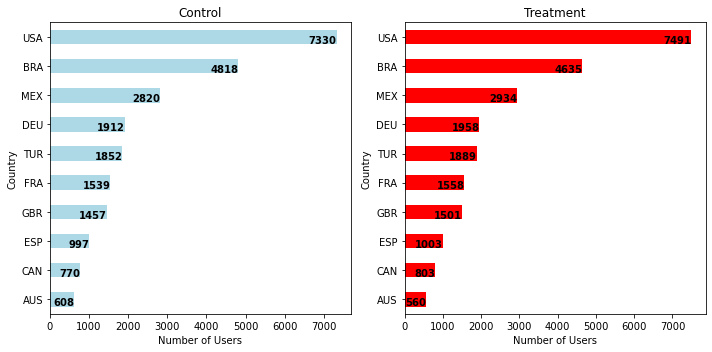

In [66]:
# Count the number of users from each country in the control and treatment dataframes
control_countries = control_df.groupby('country')['users_id'].count().sort_values(ascending=True).drop(0.0)
treatment_countries = treatment_df.groupby('country')['users_id'].count().sort_values(ascending=True).drop(0.0)

# Create a horizontal bar chart for the control and treatment dataframes
plt.figure(1, figsize=(10,5))
plt.subplot(121)
control_countries.plot(kind='barh', color='lightblue')
plt.title('Control')
plt.ylabel('Country')
plt.xlabel('Number of Users')
for i, v in enumerate(control_countries):
    plt.text(v + 5, i - 0.1, str(v), color='black', fontweight='bold', ha='right', va='center')

plt.subplot(122)
treatment_countries.plot(kind='barh', color='red')
plt.title('Treatment')
plt.ylabel('Country')
plt.xlabel('Number of Users')
for i, v in enumerate(treatment_countries):
    plt.text(v + 5, i - 0.1, str(v), color='black', fontweight='bold', ha='right', va='center')

plt.tight_layout()
plt.show()

As can be seen from the graphs the number of users from each country is very similar between both the Control and Treatment groups. This is great as it makes for a fairer test due to a less likelihood of external factors affecting the data. 

Lets follow this with a look at the overall gender distribution between groups:

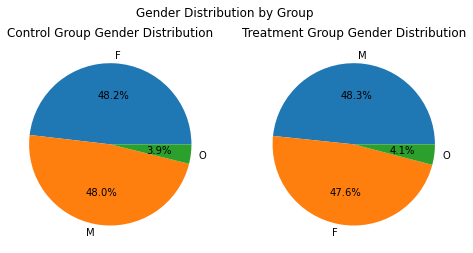

In [67]:
# Create a horizontal figure with two subplots side by side
fig, (pie1, pie2) = plt.subplots(ncols=2, figsize=(8, 4))

# Plot the pie chart for group A in the left subplot
control_gender = control_df['gender'].value_counts().drop(0.0)
pie1.pie(control_gender, labels=control_gender.index, autopct='%1.1f%%')
pie1.set_title('Control Group Gender Distribution')

# Plot the pie chart for group B in the right subplot
treatment_gender = treatment_df['gender'].value_counts().drop(0.0)
pie2.pie(treatment_gender, labels=treatment_gender.index, autopct='%1.1f%%')
pie2.set_title('Treatment Group Gender Distribution')

# Set the overall title for the figure
fig.suptitle('Gender Distribution by Group')

# Show the figure
plt.show()

Clearly both groups have very similar demographics, this suggests that any differences in behaviour between the groups (such as conversion rate or spending habits) are more likely to be correlated with the treatment rather than underlying differences in the groups themselves. This will further strengthen the validity of any test results acquired in this analysis of Globox's new banner. However, even with similar demographics there could still be other factors that could influence the result so it is important to not draw a conclusion too early.

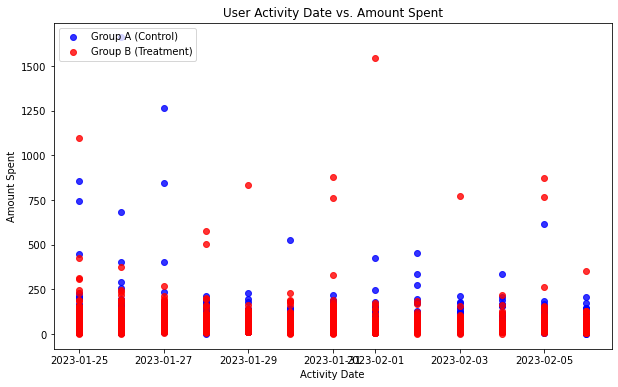

In [68]:
plt.figure(3, figsize=(10,6))
# Scatter plot of spent vs activity_device for group A (control)
plt.scatter(pd.to_datetime(control_df['date'], format='%d/%m/%Y'), control_df['spent'], color='blue', label='Group A (Control)', alpha=0.8)

# Scatter plot of group B (treatment)
plt.scatter(pd.to_datetime(treatment_df['date'], format='%d/%m/%Y'), treatment_df['spent'], color='red', label='Group B (Treatment)', alpha=0.8)

# Set the title and axis labels
plt.title('User Activity Date vs. Amount Spent')
plt.xlabel('Activity Date')
plt.ylabel('Amount Spent')
plt.legend(loc='upper left')

# Show the plot
plt.show()

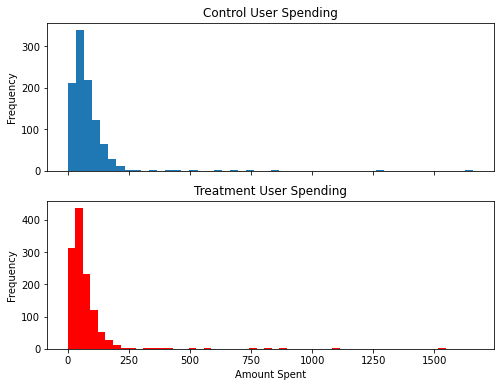

In [69]:
# Filter out zero spend values
control_spent = control_df[control_df['spent'] != 0]['spent']
treatment_spent = treatment_df[treatment_df['spent'] != 0]['spent']

# Create subplots
fig, (hist1, hist2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

# Create histogram for control_df
hist1.hist(control_spent, bins=50)
hist1.set_title('Control User Spending')
hist1.set_ylabel('Frequency')

# Create histogram for treatment_df
hist2.hist(treatment_spent, bins=50, color='red')
hist2.set_title('Treatment User Spending')
hist2.set_xlabel('Amount Spent')
hist2.set_ylabel('Frequency')

plt.show()

Now although these histograms look similar it is important to note that the y-axis for each is a different scale. From this we can see that the *Control group* makes larger amounts of high purchases, whereas the *Treatment group* makes considerably more smaller purchases.

The scatter graph also shows that date of purchase doesn't particularly matter as it is quite an even spread across both groups. Both groups have outliers, with possibly the *Treatment group* having more as the date advances into February but it is not really possible to discern from this scatter plot. What can be seen is that the number of smaller purchases of both groups is very similar across all the dates.

---

### Difference in averages
For the next stage of the analysis it's important to find the if there is an obvious difference in the average amount spent per user between groups. The *Control Group* had an average of **3.375** and the *Treatment Group* had an average of **3.391**, these values although different are clearly very similar making a conclusion impossible to draw without further investigation.   
This is an opportunity to conduct a hypothesis test using the **t-distribution** and a **5% significance level**, under the *assumption of unequal variance*.   
- Let the *Null hypothesis* be that there is no difference in the mean amount spent per user between the control and treatment groups.   
- The *Alternative hypothesis* being that there is a difference.

In [70]:
#Hypothesis test, Null hypothesis the averages are equal
# Assuming unequal variance, then unpooled standard error for test
def welch_ttest(x1, x2, col_name, alternative):
    
    n1 = len(x1)
    n2 = len(x2)
    
    m1 = avg_spent(x1)
    m2 = avg_spent(x2)
    
    v1 = np.var(x1[col_name], ddof=1)
    v2 = np.var(x2[col_name], ddof=1)
    
    unpooled_se = np.sqrt(v1/n1 + v2/n2)
    delta = m2 - m1                         # Treatment mean - Control mean
    
    df = (v1/n1 + v2/n2)**2 / ((v1/n1)**2/(n1-1) + (v2/n2)**2/(n2-1))
    tstat = delta /  unpooled_se
    
    # Default is two side t-test
    if alternative == "less":
        p = t.cdf(tstat, df)
    elif alternative == "greater":
        p = 1 - t.cdf(tstat, df)
    elif alternative == "unequal":
        p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*unpooled_se 
    ub = delta + t.ppf(0.975,df)*unpooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

# Get the T-statistics outputs from this function
print(welch_ttest(control_df, treatment_df, 'spent', "unequal"))
print("\n")

   T statistic            df  pvalue 2 sided  Difference in mean        lb        ub
0     0.072197  49022.610192        0.942445            0.016348 -0.427481  0.460178




The hypothesis test resulted in a **p-value** of **0.942**, this is statistically *insignificant*. Therefore, ***We fail to reject the null hypothesis*** that there is no difference in the mean amount spent per user between the control and treatment groups. This code also calculates the 95% confidence interval for the difference in the average amount spent per  user between the *Control* and *Treatment* groups, (-0.427, 0.460) lower and upper bounds respectively. Since the interval contains the value of **0** we cannot conclude with **95%** confidence that the treatment has a *statistically significant effect* on the average amount spent per user compared to the control.

This is further reinforced by looking at the **95%** confidence intervals for the *average amount spent per user* for both groups individually as shown below, found using a one-sample t-interval for means:

In [71]:
# Calculate the 95% confidence interval for the average amount spent per user
def one_sample_t_ci(sample_df, col_name, alpha=0.05):
    """
    Calculates the confidence interval for the population mean of a specified column in a DataFrame,
    using a one-sample t-interval for means.
    
    Parameters:
        sample_df (DataFrame): The DataFrame containing the data
        col_name (str): The name of the column for which to calculate the confidence interval
        alpha (float): The significance level for the confidence interval (default=0.05)
        
    Returns:
        A tuple containing the lower and upper bounds of the confidence interval
    """
    total_spent = sample_df.groupby('users_id')['spent'].sum()      # Average spent per user
    sample_mean = total_spent.mean()
    sample_std = sample_df[col_name].std(ddof=1)  # Use ddof=1 for unbiased estimate of sample standard deviation
    n = len(sample_df)-1
    std_error = sample_std / (n ** 0.5)
    sample_df_t = n - 1
    ci = stats.t.interval(1 - alpha, sample_df_t, loc=sample_mean, scale=std_error)
    return ci

# 95% confidence interval for Control
ci_control = one_sample_t_ci(control_df, 'spent')
print("95% confidence interval for Control: " + str(round(ci_control[0], 3)) + ", " + str(round(ci_control[1], 3)))
# 95% confidence interval for Treatment
ci_treatment = one_sample_t_ci(treatment_df, 'spent')
print("95% confidence interval for Treatment: " + str(round(ci_treatment[0], 3)) + ", " + str(round(ci_treatment[1], 3)) + "\n")

95% confidence interval for Control: 3.056, 3.693
95% confidence interval for Treatment: 3.082, 3.7



This shows that both the upper and lower bounds for confidence interval of the *Control* and *Treatment* groups were almost identical.

---

### Conversion Rates
The next important factor to consider is conversion rate. Although it is not possible to say that the average spent between groups was different, the banner could of had an effect on the activity and number of purchases made by users. The method in which the conversion rate was found is shown below:

In [72]:
# User conversion rate
def conversion_rate(x1):
    '''
    Calculates the conversion rate of a dataframe dependant on the 'spent' column and grouped by user
    
    Parameters:
        x1 (DataFrame): The DataFrame containing the data of df

    Returns:
        x1_converted : Returns the length of the sorted dataframe
        x1_rate : Percentage conversion rate rounded to 2 d.p. of df
    '''
    x1_converted = len(x1.where(x1['spent'] > 0).groupby('users_id')['spent'].sum())        # Combining a where and groupby clause for 'spent' > 0 meaning converted
    x1_rate = round((x1_converted / len(x1)) * 100, 2)                                      # Divide by total and x100 for percentage
    return x1_converted, x1_rate

con_A = conversion_rate(control_df)
print('Control conversion rate = ' + str(con_A[1]) + '%')
con_B = conversion_rate(treatment_df)
print('Treatment conversion rate = ' + str(con_B[1]) + '%' + "\n")

Control conversion rate = 3.91%
Treatment conversion rate = 4.62%



Now this is a more noticable difference, performing a **95%** confidence interval check on both groups will futher point us towards a conclusion. As the **sample size** is large (in the thousands) and the **conversion rate** is not extremely small or large it is reasonable to use the normal distribution to calculate both the confidence intervals and conduct an hypothesis test for the difference in conversion rates between the *Control* and *Treatment* groups.

In [73]:
# Confidence interval for conversion rate using normal distribution
def conversion_rate_ci(df):
    '''
    Calculates the 95% Confidence Interval for the conversion rate using the normal distribution
    Parameters:
        df (DataFrame): The DataFrame containing the data

    Returns:
        ci : A tuple containing the lower and upper bounds of the confidence interval
    '''
    p = conversion_rate(df)[0] / len(df)                                                # Calculating sample proportion     
    n = len(df)
    se = np.sqrt(p * (1-p) / n)                                                         # Standard error of the proportion
    z = stats.norm.ppf(0.975)
    ci = round((p - z*se), 5), round((p + z*se), 5)                                     # Rounding the Confidence Interval to 5 d.p.
    return ci

ci_con_control = conversion_rate_ci(control_df)
print("95% confidence interval of conversion rate for CONTROL group using normal distribution:")
print(ci_con_control)
print("\n")
ci_con_treatment = conversion_rate_ci(treatment_df)
print("95% confidence interval of conversion rate for TREATMENT group using normal distribution:")
print(ci_con_treatment)
print("\n")

95% confidence interval of conversion rate for CONTROL group using normal distribution:
(0.0367, 0.04157)


95% confidence interval of conversion rate for TREATMENT group using normal distribution:
(0.04353, 0.04877)




From this we can say that we are ***95%** confident* that the *true conversion rate* for the *Control* group is between the lower and upper bounds of 0.0367 and 0.04157, conversely the true conversion rate for the *Treatment* group is between 0.04353 and 0.04877. Furthermore, the confidence intervals do not overlap at all, which suggests that there may be **a significant difference** between the conversion rates of the two groups. 

Lets follow this up with an hypothesis test to see whether there is a difference in the conversion rate between the two groups. Using the *normal distribution*, a *5% significance level* and the *pooled proportion* for the *standard error*. This is a two-sample two-sided z-interval for the difference in proportions where proportions are assumed to be equal.

In [74]:
def two_sample_ztest_prop(x1, x2):
    '''
    Performs a 2 sample, two sided hypothesis test to see if there is a difference in conversion rate between the groups
    Parameters:
        x1 (DataFrame): The DataFrame containing the data of first df
        x2 (DataFrame): The DataFrame containing the data of second df

    Returns:
        z : Z-score of the hypothesis test
        p : The p-value of the hypothesis test
        lb : Lower bound of confidence interval
        up: Upper bound of confidence interval
    '''
    n1 = len(x1)
    n2 = len(x2)
    
    x1_converted = conversion_rate(x1)[0]                       # Hypothesis test is based on conversion rate so needs to be recalculated
    x2_converted = conversion_rate(x2)[0]                       # Used the function created earlier
    
    p1 = x1_converted / n1                                      # Proportion of first df
    p2 = x2_converted / n2                                      # Proportion of second df
    pc = (x1_converted + x2_converted) / (n1 + n2)              # Calculate pooled proportion
    
    z = (p1 - p2) / np.sqrt(pc * (1 - pc) * (1/n1 + 1/n2))      # Test statistic calc, Z-score
    p = 2 * (1 - stats.norm.cdf(abs(z)))                        # And p-value
    
    # Confidence Interval calc
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)                   # Unpooled standard error
    
    z = stats.norm.ppf(0.975)                                   # Critical Z value
    
    lb = (p2 - p1) - z * se                                     # Lower and upper bound calculations
    ub = (p2 - p1) + z * se
    
    return z, p, lb, ub

z, p, lb, ub = two_sample_ztest_prop(control_df, treatment_df)
print("z-score:", z)
print("p-value:", p)
print("\n")

z-score: 1.959963984540054
p-value: 0.0001206799120245794




The resulting **p-value** obtained is **0.00012**, which is a lot less than the *significance level* of **0.05**, this means that ***we can reject the null hypothesis***. There is a statistically significant difference in the conversion rates between the Control and Treatment groups.

Moreover, as discovered above the Treatment group having a confidence interval of (**0.04353, 0.04877**)  which is completely outside the Control group's interval of (**0.0367, 0.04157**).

To put the final nail in the coffin, looking at the 95% confidence interval for the difference in the conversion rate between the treatment and control. This was calculated in the code above so just needs to be printed out.

In [75]:
print("95% confidence interval for the difference in conversion rate between groups:")
print("Lower bound:", lb)
print("Upper bound:", ub)

95% confidence interval for the difference in conversion rate between groups:
Lower bound: 0.0034408383660435196
Upper bound: 0.010588347540417636


We can be **95%** confident that the true difference in conversion rate between the Treatment and Control groups lies between (**0.00344, 0.0106**). The interval *does not include* **0**, suggesting *there is a statistically significant difference* between the two. Therefore, it is safe to say that there is a positive difference between the two groups and that the Treatment group has a higher success chance of a user converting.

### Conclusion

From these tests I would recommend implementing the new 'Food and Drink' banner on Globox's mobile website as we have seen from this final test there is a ***statistically significant difference*** between the two groups with the *Treatment group* having a higher conversion rate, where the **95%** confidence interval for the difference in conversion rate for the *Treatment group* (**0.04353, 0.04877**) lay completely outside the *Control group's* interval (**0.0367, 0.04157**).

With more customers converting and making purchases on the website it is likely that profits will increase with time, so even though the current hypothesis test results for the amount spent between the two groups was a failure to reject the null hypothesis (no difference), this is likely to change with time.